![A soccer pitch for an international match.](soccer-pitch.jpg)

***Scenario:*** You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question we are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
import pandas as pd

# read data
df_men_socc = pd.read_csv('./data/men_results.csv')
df_women_socc = pd.read_csv('./data/women_results.csv')
# check the columns
print(df_men_socc.columns)
print(df_women_socc.columns)

Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')
Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')


In [2]:
# drop the redundant index column
df_men_socc.drop('Unnamed: 0', axis='columns', inplace=True)
df_women_socc.drop('Unnamed: 0', axis='columns', inplace=True)
# add gender column so we can combine
df_men_socc['gender'] = "men"
df_women_socc['gender'] = "women"
# combine
df_all = pd.concat([df_men_socc, df_women_socc], ignore_index=True)
print(f"shape BEFORE any filtering: {df_all.shape}")
df_all.head()

shape BEFORE any filtering: (49237, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
0,1872-11-30,Scotland,England,0,0,Friendly,men
1,1873-03-08,England,Scotland,4,2,Friendly,men
2,1874-03-07,Scotland,England,2,1,Friendly,men
3,1875-03-06,England,Scotland,2,2,Friendly,men
4,1876-03-04,Scotland,England,3,0,Friendly,men


In [3]:
# remove all rows before 2002-01-01
print(f"shape BEFORE removing matches before 2002-01-01: {df_all.shape}")
df_all = df_all.loc[df_all['date'] >= '2002-01-01'].copy()
print(f"shape AFTER removing matches before 2002-01-01: {df_all.shape}")
df_all.head()

shape BEFORE removing matches before 2002-01-01: (49237, 7)
shape AFTER removing matches before 2002-01-01: (23009, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men


## Remove qualifier matches

In [4]:
tournaments = df_all["tournament"].value_counts()
is_qual = tournaments.index.str.contains("qualification")
non_quals = tournaments[~is_qual]
# print(is_qual, '\n')
print(tournaments, '\n')
print(non_quals, '\n')
print(f"total count of tournament types BEFORE filtering: {len(tournaments)}")
print(f"total count of tournament types  AFTER filtering: {len(non_quals)} \n")

tournament
Friendly                                6936
FIFA World Cup qualification            4340
UEFA Euro qualification                 2149
African Cup of Nations qualification     968
FIFA World Cup                           584
                                        ... 
Copa América qualification                 2
Atlantic Heritage Cup                      2
Copa Confraternidad                        1
TIFOCO Tournament                          1
CONMEBOL–UEFA Cup of Champions             1
Name: count, Length: 100, dtype: int64 

tournament
Friendly                          6936
FIFA World Cup                     584
UEFA Nations League                468
Algarve Cup                        430
African Cup of Nations             405
                                  ... 
Copa Paz del Chaco                   2
Atlantic Heritage Cup                2
Copa Confraternidad                  1
TIFOCO Tournament                    1
CONMEBOL–UEFA Cup of Champions       1
Name: count, 

In [5]:
# remove all rows of qualification matches
print(f"shape BEFORE removing qualification matches: {df_all.shape}")
df_all = df_all.loc[df_all['tournament'].isin(non_quals.index)].copy()
print(f"shape AFTER removing qualification matches: {df_all.shape}")
df_all.head()

shape BEFORE removing qualification matches: (23009, 7)
shape AFTER removing qualification matches: (14060, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men


## Remove all non-FIFA matches

In [6]:
print(df_all["tournament"].value_counts()["FIFA World Cup"])  # 584
df_all_fifa = df_all[df_all['tournament'] == "FIFA World Cup"].copy()  # avoids SettingWithCopyWarning 2 cells down
print(df_all_fifa.shape)  # should be 584
df_all_fifa["gender"].value_counts()  # not horribly lopsided...

584
(584, 7)


gender
men      384
women    200
Name: count, dtype: int64

In [7]:
# add column of total goals scored needed for comparison
df_all_fifa["total_goals"] = df_all_fifa['home_score'] + df_all_fifa['away_score']

print(df_all_fifa[df_all_fifa["gender"] == "men"].describe(), '\n')    # 384
print(df_all_fifa[df_all_fifa["gender"] == "women"].describe(), '\n')  # 200

# df_all_fifa.to_csv("./data/df_fifa.csv")  # save the processed data, only do once

df_all_fifa.head()

       home_score  away_score  total_goals
count  384.000000  384.000000   384.000000
mean     1.375000    1.138021     2.513021
std      1.328538    1.107398     1.652544
min      0.000000    0.000000     0.000000
25%      0.000000    0.000000     1.000000
50%      1.000000    1.000000     2.000000
75%      2.000000    2.000000     3.000000
max      8.000000    7.000000     8.000000 

       home_score  away_score  total_goals
count  200.000000  200.000000   200.000000
mean     1.805000    1.175000     2.980000
std      1.937977    1.289453     2.022387
min      0.000000    0.000000     0.000000
25%      1.000000    0.000000     2.000000
50%      1.000000    1.000000     3.000000
75%      2.000000    2.000000     4.000000
max     13.000000    7.000000    13.000000 



,date,home_team,away_team,home_score,away_score,tournament,gender,total_goals
25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,men,1
25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,men,8
25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,men,2
25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,men,3
25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,men,1


## Goal distributions

Before selecting a test to test our hypothesis, let's looks at the shape of the total goals distributions. The dashed vertical lines are the means of each distribution. The mean of the womens distribution is a little larger than that of the men, but it is not obvious that this difference is significant.

These are Poisson distributions, so selecting a test that assumes normality of the underlying distributions is not a good idea.

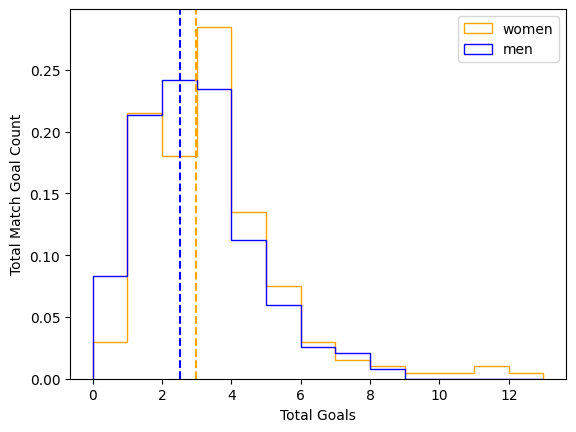

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

goal_bins = range(14)
men_mean = df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'].mean()
women_mean = df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'].mean()

fig, ax = plt.subplots()
ax.hist(df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'],
        label="women", bins=goal_bins, histtype="step", density=True, color='orange')
ax.hist(df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'],
        label="men", bins=goal_bins, histtype="step", density=True, color='blue')
ax.set_xlabel("Total Goals")
ax.set_ylabel("Total Match Goal Count")
ax.legend()
plt.axvline(x=men_mean, color='blue', linestyle='--')     # men mean
plt.axvline(x=women_mean, color='orange', linestyle='--') # women mean

plt.show()

## Mann-Whitney U rank test

Since these distibution of goals in FIFA matches are not normal (because they are Poisson), a non-parametric approach such as the *Mann-Whitney U rank test* would be a reasonable choice.

In [9]:
def test_hypothesis(alpha, p_val):
    """ Evaluates a test of a hypothesis

    Args:
      alpha (float): significance level of the hypothesis test
      p_val (float): probability that the null hypothesis is true
    
    """
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

In [10]:
from scipy.stats import mannwhitneyu

alpha = 0.10

stat, p_val_mannwh = mannwhitneyu(
    df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'],
    df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'],
    alternative='greater'  # HA: women score more goals
)

def test_hypothesis(alpha, p_val):
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

result_dict = test_hypothesis(alpha, p_val_mannwh)

print(f"Mann-Whitney U test p-value: {result_dict['p_val']}")
print(f"At alpha = {alpha}, we {result_dict['result']} the null hypothesis that means are the same in favor of the alternative hypothesis")

Mann-Whitney U test p-value: 0.005106609825443641
At alpha = 0.1, we reject the null hypothesis that means are the same in favor of the alternative hypothesis


## Testing two Poisson Means

The results of an "E-test", which was developed for this situation:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson_means_test.html

gives an even smaller p-value and also concludes that we should reject the null hypothesis in favor of women's matches scoring more goals than men.

In [11]:
# gather values for E-test
k_women_goals_fifa = df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'].sum()     # 596
n_women_goals_fifa = df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'].shape[0]  # 200
k_men_goals_fifa = df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'].sum()         # 965
n_men_goals_fifa = df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'].shape[0]      # 384

In [34]:
from scipy.stats import poisson_means_test

_, p_val_e = poisson_means_test(k1=k_women_goals_fifa, n1=n_women_goals_fifa,
                                k2=k_men_goals_fifa, n2=n_men_goals_fifa,
                                diff=0, alternative="greater")

print("Results of the Poisson E-test:")
print(f"At alpha = {alpha} and p-value = {p_val_e}, we reject the null hypothesis that means are the same in favor of the alternative hypothesis")

Results of the Poisson E-test:
At alpha = 0.1 and p-value = 0.0005775386675576889, we reject the null hypothesis that means are the same in favor of the alternative hypothesis


## Another approach: distribution of differences

Although this data is not paired, what if we took the Cartesian product of all men and women's matches, took the differences in goals and used this distibution to test the null hypothesis?

### Visualizing the distribution of differences

In [13]:
import itertools
import numpy as np
# Cartesian product of all men and women matches
# total_women_men_match_scores = tuple(
#     itertools.product(
#         df_all_fifa[df_all_fifa["gender"] == "women"]['total_goals'],
#         df_all_fifa[df_all_fifa["gender"] == "men"]['total_goals']
#     )
# )

# women_goals = [x[0] for x in total_women_men_match_scores]
# men_goals = [x[1] for x in total_women_men_match_scores]
# goal_diffs = [x[0] - x[1] for x in total_women_men_match_scores]

# df_cart_diffs = pd.DataFrame({
#     "women": women_goals,
#     "men": men_goals,
#     "diff": goal_diffs
# })

# df_cart_diffs.shape  # (76800, 3)
# df_cart_diffs.to_csv('./data/df_cart_diffs.csv')  # save the processed data, only do once

df_cart_diffs = pd.read_csv('./data/df_cart_diffs.csv')
df_cart_diffs.head()

,women,men,diff
0,3,1,2
1,3,8,-5
2,3,2,1
3,3,3,0
4,3,1,2


largest difference in goals between men and women's matches = 13
Total cartesian product matches: 76800


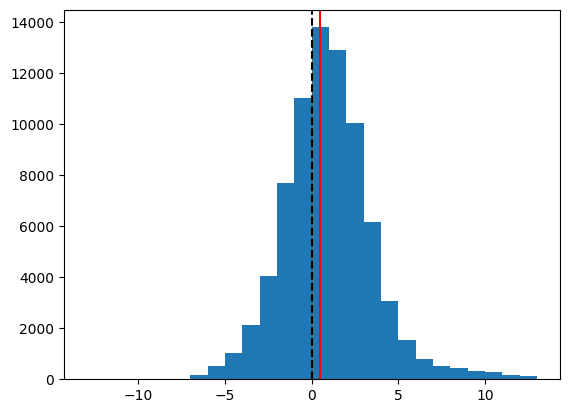

In [14]:
max_diff = max(abs(df_cart_diffs['diff'].max()), abs(df_cart_diffs['diff'].min()))
print(f"largest difference in goals between men and women's matches = {max_diff}")
bin_diffs = range(-max_diff, max_diff+1)

print(f"Total cartesian product matches: {len(df_cart_diffs)}")                   # should be 76800, check

# What does the distribution of these diff look like?
fig, ax = plt.subplots()
ax.hist(df_cart_diffs['diff'],
        label="score diffs",
        bins=bin_diffs)
# add reference lines
act_mean_cart = df_cart_diffs['diff'].mean()
plt.axvline(x=act_mean_cart, color='red')        # actual mean
plt.axvline(x=0, color='black', linestyle='--')  # hypothesized mean
plt.show()

The above distribution is clearly shifted to the right of 0 (black dashed line), but the red line doesn't look significantly different from the black dashed zero line.

## Difference distribution has left skew

The above distribution looks relatively normal, however the right tail is noticeably thicker. Since it's not normal, it's not surprise that the result of running a z-test give a result different from the prior two tests. 

In [15]:
from scipy.stats import norm

hyp_mean = 0
std_error_cart = np.std(df_cart_diffs['diff'], ddof=1)
z_score_cart = (act_mean_cart - hyp_mean) / std_error_cart
p_value_cart = 1 - norm.cdf(z_score_cart, loc=0, scale=1)  # HA: women goals > men goals
print(f"mean of cartesian product diffs = {act_mean_cart}, std error = {std_error_cart} | z score = {z_score_cart} | p-value = {p_value_cart}")

mean of cartesian product diffs = 0.46697916666666667, std error = 2.6064299814051477 | z score = 0.17916428601504744 | p-value = 0.4289043527857148


## Bootstrap distribution

When we aren't sure what the underlying distribution of the statistic we are interested in looks like, a non-parametric test such as the ***Mann-Whitney U*** test used above is a reasonable choice. Another possibility is to utilize the ***Central Limit Theorem (CLT)*** and a boostrap distribution. This approach is explored below.

### Process

1. Take a sample from the women's matches with replacement
2. Take a sample from the men's matches with replacement
3. Compute the difference in goals between the sampled matches: (women's goals - men's goals)
4. Repeat 1. thru 3. 100 times and compute the mean of the 100 difference. This is one sample in the ***Mean of Sample Mean of Goal Differences*** distribution
5. Repeat 1. thru 4. 1000 times to create the distribution of ***Mean of Sample Mean of Goal Differences***

From the **CLT**, we expect this distribution to be normal which we verify below. From this distribution, when we run a standard z-test, we again see that we should reject $H_0$ (mean of differences are equal) in favor of $H_A$ (mean of differences (women - men) > 0).

Of the three approaches explored, this last one gave a p-value that was higher than the other two.

In [26]:
goals_women = df_all_fifa[df_all_fifa["gender"] == "women"]['total_goals']
goals_men = df_all_fifa[df_all_fifa["gender"] == "men"]['total_goals']

n_mean_sample = 100  # number of samples used to compute a single mean in the distribution of means
n_dist_means = 1000  # number of means in the distribution of means
sample_means = []
for i in range(n_dist_means):  #
    samples_in_each_mean = []
    for j in range(n_mean_sample):  # samples taken to compute a single mean
        # sample from women and men match and compute diff
        sample_women = goals_women.sample(n=1, replace=True).values[0]
        sample_men = goals_men.sample(n=1, replace=True).values[0]
        diff = sample_women - sample_men
        samples_in_each_mean.append(diff)
        # print(f"i={i}, j={j}, sample_women={sample_women}, sample_men={sample_men}, diff={diff}")
    sample_mean = np.mean(samples_in_each_mean)
    sample_means.append(sample_mean)
    # print(f"i={i}, sample_mean={sample_mean}")

max_diff = np.max(np.abs(sample_means))
print(f"largest difference in goals between men and women's matches = {max_diff}")

largest difference in goals between men and women's matches = 1.25


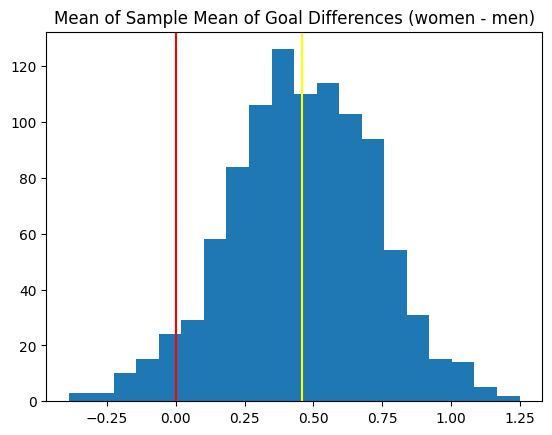

In [30]:
# What does the bootstrap distribution of these diff look like?
fig, ax = plt.subplots()
ax.hist(sample_means,
        label="bootstap_score_diffs",
        bins=20)
ax.set_title("Mean of Sample Mean of Goal Differences (women - men)")
# add reference lines
act_mean_boot = np.mean(sample_means)
plt.axvline(x=act_mean_boot, color='yellow')  # actual mean
plt.axvline(x=0, color='red')                 # hypothesized mean
plt.show()

In [33]:
hyp_mean_mean = 0
std_error_boot = np.std(sample_means, ddof=1)
z_score_boot = (act_mean_boot - hyp_mean_mean) / std_error_boot
p_value_boot = 1 - norm.cdf(z_score_boot, loc=0, scale=1)  # HA: women goals > men goals (yellow line is right of 0)
print(f"mean of bootstrap diffs = {act_mean_boot}, std error = {std_error_boot} | z score = {z_score_boot} | p-value = {p_value_boot}")

mean of bootstrap diffs = 0.45994, std error = 0.2632685068645825 | z score = 1.7470376744932106 | p-value = 0.040315401613186586


## What if we increased our bootstrap samples?

### WARNING: The next cell is very computationally exensive!

It took about **15 minutes** to run on my Ryzen 7 system.

In [35]:
n_mean_sample = 1000  # number of samples used to compute a single mean in the distribution of means
n_dist_means = 10000  # number of means in the distribution of means
sample_means = []
for i in range(n_dist_means):  #
    samples_in_each_mean = []
    for j in range(n_mean_sample):  # samples taken to compute a single mean
        # sample from women and men match and compute diff
        sample_women = goals_women.sample(n=1, replace=True).values[0]
        sample_men = goals_men.sample(n=1, replace=True).values[0]
        diff = sample_women - sample_men
        samples_in_each_mean.append(diff)
        # print(f"i={i}, j={j}, sample_women={sample_women}, sample_men={sample_men}, diff={diff}")
    sample_mean = np.mean(samples_in_each_mean)
    sample_means.append(sample_mean)
    # print(f"i={i}, sample_mean={sample_mean}")

max_diff = np.max(np.abs(sample_means))
print(f"largest difference in goals between men and women's matches = {max_diff}")

largest difference in goals between men and women's matches = 0.756


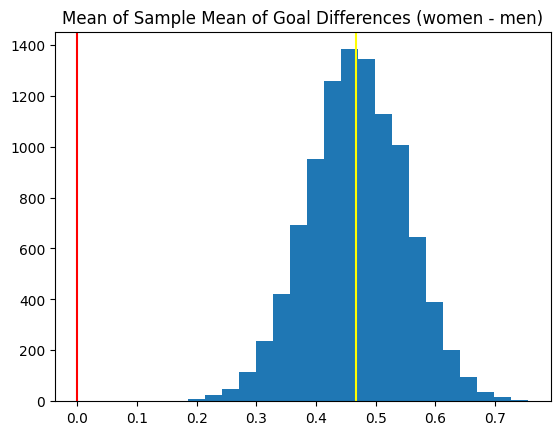

In [37]:
# How does increasing the bootstrap sample size change the distribution of diff's?
fig, ax = plt.subplots()
ax.hist(sample_means,
        label="bootstap_score_diffs",
        bins=20)
ax.set_title("Mean of Sample Mean of Goal Differences (women - men)")
# add reference lines
act_mean_boot2 = np.mean(sample_means)
plt.axvline(x=act_mean_boot2, color='yellow')  # actual mean
plt.axvline(x=0, color='red')                 # hypothesized mean
plt.show()

In [38]:
hyp_mean_mean = 0
std_error_boot2 = np.std(sample_means, ddof=1)
z_score_boot2 = (act_mean_boot2 - hyp_mean_mean) / std_error_boot2
p_value_boot2 = 1 - norm.cdf(z_score_boot2, loc=0, scale=1)  # HA: women goals > men goals (yellow line is right of 0)
print(f"mean of bootstrap diffs = {act_mean_boot2}, std error = {std_error_boot2} | z score = {z_score_boot2} | p-value = {p_value_boot2}")

mean of bootstrap diffs = 0.4679415, std error = 0.081371369705387 | z score = 5.750689729006996 | p-value = 4.444004830794768e-09


As we expect, the mean diff stayed about the same, the std error dropped, the z-score increased and the p-value dropped substantially. This leaves us with three approaches which all point to the same conclusion: ***We reject the null hypothesis that mean of total goals scored between women and men's matches are the same in favor of the altenative the mean of total goals scored in womens matches is greater than the total goals scored in mens matches.***